In [22]:
import json, random
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle
import copy
import spacy
from spacy import displacy
from itertools import tee
import wikipedia
import pylcs
import string
np.set_printoptions(precision=4)

In [2]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_J.json", "r"))
print(len(txt_dataset))

7921


In [506]:
# Randomly look at positive facts and the wikipedia pages they come from
analyze_ids = random.sample(range(7921), 15)
print(analyze_ids)
for i in analyze_ids:
    k = str(i)
    print('Q: ', txt_dataset[k]['Q'])
    print('A: ', txt_dataset[k]['A'])
    for f in txt_dataset[k]['SupportingFacts']:
        print(f['fact'])
        print(f['url'])
    print()

[4330, 982, 5834, 6850, 3781, 697, 3929, 2376, 5909, 4968, 5537, 1581, 6812, 6693, 2102]
Q:  Did Nickelodeon or Netflix premiere Winx episodes first?
A:  Nickelodeon was first as it premiered the Winx Club series in 2012, whereas Netflix premiered the Winx Saga in 2021.
Its television premiere was on 11 March 2012 on Nickelodeon in the United States. The plot takes place after the events of the first three seasons. In 2007, production began on a sequel to The Secret of the Lost Kingdom, before the fourth season had been written. It was released in Italy on 29 October 2010.
https://en.wikipedia.org/wiki/List_of_Winx_Club_episodes
The six-episode first season debuted on Netflix on 22 January 2021 to mixed reviews. In February 2021, the series was renewed for a second season. Bloom, a fairy with fire powers, enrolls at a magical boarding school in the Otherworld called Alfea College.
https://en.wikipedia.org/wiki/Fate:_The_Winx_Saga

Q:  What is a concept that is centrally emphasized by b

Step 1: Question --> Identify salient spans

Step 2: Spans --> Wiki pages

Step 3: Wikipages --> html parsing --> paragraphs, images & their captions

Step 4: Choose paragraphs with high overlap with the question **without** giving away the core answer info

#### Step 1: Question --> Identify salient spans

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
def show_ents(doc): 
    if doc.ents: 
        for ent in doc.ents: 
            print(ent.text+' - ' +str(ent.start_char) +' - '+ str(ent.end_char) +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_))) 
    else: print('No named entities found.')

In [561]:
ids = random.sample(range(7921), 5)
for i in ids:
    k = str(i)
    print(k)
    Q = txt_dataset[k]['Q']
    print('Q: ', Q)
    print('A: ', txt_dataset[k]['A'])
    for f in txt_dataset[k]['SupportingFacts']:
        print(f['fact'])
        print(f['url'])
    print("\nEntities:")
    doc = nlp(Q)
    show_ents(doc)
    if doc.ents: displacy.render(doc, style='ent', jupyter=True)
    for e in doc.ents:
        print(wikipedia.search(e.text))
    print(" ---------------------------------------------------------------------------- \n")

5114
Q:  How much higher did Take That & Party peak on the UK Albums Chart than Having a Party peaked on the Billboard Hot 100?
A:  Take That & Party peaked 15 spots spots higher on it's respective chart.
Released on 17 August 1992 on RCA Records, it reached number two on the UK Albums Chart and stayed in the UK Top 75 album chart for 73 weeks (one year, five months and one week). It was their only album not to reach number one until Wonderland peaked at number two in 2017.
https://en.wikipedia.org/wiki/Take_That_%26_Party
The song peaked at number four on Billboard 's Hot R&B Sides chart, and also charted at number 17 on the Billboard Hot 100 . "Having a Party", like its A-side, "Bring It On Home to Me", was written while Cooke was on tour for Henry Wynn.
https://en.wikipedia.org/wiki/Having_a_Party_(song)

Entities:
Take That & Party - 20 - 37 - ORG - Companies, agencies, institutions, etc.
UK - 50 - 52 - GPE - Countries, cities, states
Party - 80 - 85 - ORG - Companies, agencies, in

['Take That & Party', 'Take That', 'List of songs recorded by Take That', 'Take That discography', 'Wonderland (Take That album)', 'Greatest Hits (Take That album)', 'Could It Be Magic', 'Take That Presents: The Circus Live', 'III (Take That album)', 'Jason Orange']
['United Kingdom', 'Countries of the United Kingdom', '.uk', '2016 United Kingdom European Union membership referendum', 'List of political parties in the United Kingdom', 'UK garage', 'Postcodes in the United Kingdom', 'Sky UK', 'Prime Minister of the United Kingdom', 'UK Biobank']
['Party', 'Political party', 'Labour Party (UK)', 'Republican Party (United States)', 'Political parties in the United States', 'Social Democratic Party of Germany', 'One-party state', 'Democratic Party (United States)', 'Black Panther Party', 'National Party of Australia']
['100', '100 metres', '100%', 'Nasdaq-100', '$100', 'The 100', 'Time 100', 'Billboard Hot 100', "List of men's footballers with 100 or more international caps", '$100 hamburg

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


 ---------------------------------------------------------------------------- 

515
Q:  What cardinal region of Hartford, Connecticut do the American soccer team Hartford City FC and University of Hartford's Hartford Hawks lie in?
A:  In West Hartford.
The Hartford Hawks are the NCAA Division I athletic teams of the University of Hartford, located in West Hartford, Connecticut.
https://en.wikipedia.org/wiki/Hartford_Hawks_softball
Hartford City FC is an American soccer team based in West Hartford, Connecticut. The team plays in the National Premier Soccer Leagues' Northeast Region, North Atlantic Conference.
https://en.wikipedia.org/wiki/Hartford_City_FC

Entities:
Hartford - 24 - 32 - GPE - Countries, cities, states
Connecticut - 34 - 45 - GPE - Countries, cities, states
American - 53 - 61 - NORP - Nationalities or religious or political groups
Hartford City FC - 74 - 90 - GPE - Countries, cities, states
University of Hartford's - 95 - 119 - ORG - Companies, agencies, institutions, et

['Hartford, Connecticut', 'The Hartford', 'Hartford Whalers', 'Travelers Championship', 'Dee Hartford', 'Greater Hartford', 'Asa Hartford', 'Hartford Athletic', 'Hartford Courant', 'Eden Hartford']
['Connecticut', 'The Haunting in Connecticut', 'Hartford, Connecticut', 'University of Connecticut', 'Connecticut River', 'List of municipalities in Connecticut', 'Bridgeport, Connecticut', 'Stamford, Connecticut', 'Sandy Hook Elementary School shooting', 'Connecticut Lakes']
['American', 'White Americans', 'American Express', 'African Americans', 'American Airlines', 'American Samoa', 'American football', 'American Idol', 'German Americans', 'American bison']
['Hartford City FC', 'Hartford City', 'Hartford, Connecticut', 'Hartford Athletic', 'National Premier Soccer League', 'Asa Hartford', 'Boston City FC', '2017 NPSL season', 'Al-Marzook Field at Alumni Stadium', 'New York City FC']
['University of Hartford', 'Hartford, Connecticut', 'West Hartford, Connecticut', 'Hartford Hawks', 'Univer

 ---------------------------------------------------------------------------- 

1192
Q:  What continents do the 31st parallel north and the 38th parallel north both cross?
A:  Asia and North America
The 38th parallel north is a circle of latitude that is 38 degrees north of the Earth's equatorial plane. It crosses Europe, the Mediterranean Sea, Asia, the Pacific Ocean, North America, and the Atlantic Ocean. The 38th parallel north formed the border between North and South Korea prior to the Korean War .
https://en.wikipedia.org/wiki/38th_parallel_north
In the United States, the 31st parallel defines part of the border between Mississippi and Louisiana, and part of the border between Alabama and Florida. The 31st parallel north is a circle of latitude that is 31 degrees north of the Earth's equatorial plane. It crosses Africa, Asia, the Pacific Ocean, North America and the Atlantic Ocean .
https://en.wikipedia.org/wiki/31st_parallel_north

Entities:
38th - 51 - 55 - ORDINAL - "first", "

['38th parallel north', '38th Street gang', '38th Street (Minneapolis)', '38th Infantry Division (United States)', 'Korean War', '38th Academy Awards', '38th Infantry Regiment (United States)', '38th Regiment', '38th Filmfare Awards', '38th SS-Grenadier-Division "Nibelungen"']
 ---------------------------------------------------------------------------- 



In [574]:
ids = random.sample(range(7921), 8)
for i in ids:
    k = str(i)
    Q = txt_dataset[k]['Q']
    print('Q: ', Q)
    for f in txt_dataset[k]['SupportingFacts']:
        print(f['url'])
        print(" ".join(f['url'].split('/')[-1].split("_")))
    doc = nlp(Q)
    if doc.ents: displacy.render(doc, style='ent', jupyter=True)
    else: print("No entities found")
    print(" ---------------------------------------------------------------------------- \n")

Q:  What commercially viable rock could you find near St., Thomas Mount?
https://en.wikipedia.org/wiki/St._Thomas_Mount
St. Thomas Mount
https://en.wikipedia.org/wiki/Stones_of_India
Stones of India


 ---------------------------------------------------------------------------- 

Q:  Which partner in the Byzantine–Venetian Treaty of 1082 had the statues of a pair of armored late Roman emperors embracing each other last?
https://en.wikipedia.org/wiki/Ionian_Islands_under_Venetian_rule
Ionian Islands under Venetian rule
https://en.wikipedia.org/wiki/Portrait_of_the_Four_Tetrarchs
Portrait of the Four Tetrarchs


 ---------------------------------------------------------------------------- 

Q:  What was the name of the deceased Desperate Housewives character that was friends with both the character who was originally planned to be interested in Orson Hodge and the character who ends up being interested in Orson?
https://en.wikipedia.org/wiki/Acquaintances_of_Gabrielle_Solis
Acquaintances of Gabrielle Solis
https://en.m.wikipedia.org/wiki/Paul_Young_(Desperate_Housewives)
Paul Young (Desperate Housewives)
https://en.wikipedia.org/wiki/Orson_Hodge_(Desperate_Housewives)
Orson Hodge (Desperate Housewives)


 ---------------------------------------------------------------------------- 

Q:  Were Cerdanya and Urgell still united when Wilfred was Count of Cerdanya?
https://en.wikipedia.org/wiki/County_of_Cerdanya
County of Cerdanya
https://en.wikipedia.org/wiki/Wifred_II,_Count_of_Cerdanya
Wifred II, Count of Cerdanya


 ---------------------------------------------------------------------------- 

Q:  Were there the same number of laps in both the 1961 and 1963 Syracuse Grand Prix?
https://en.wikipedia.org/wiki/1963_Syracuse_Grand_Prix
1963 Syracuse Grand Prix
https://en.wikipedia.org/wiki/1961_Syracuse_Grand_Prix
1961 Syracuse Grand Prix


 ---------------------------------------------------------------------------- 

Q:  A passage grave was a type of grave used primarily in which of the time periods in which Entrance graves were used?
https://en.wikipedia.org/wiki/Passage_grave
Passage grave
https://en.wikipedia.org/wiki/Entrance_grave
Entrance grave


 ---------------------------------------------------------------------------- 

Q:  How many years were there between the earliest known football match involving a women's French team and the suspension of the Ligue 1 season for COVID?
https://en.wikipedia.org/wiki/2019%E2%80%9320_Ligue_1
2019%E2%80%9320 Ligue 1
https://en.wikipedia.org/wiki/Women%27s_football_in_France
Women%27s football in France


 ---------------------------------------------------------------------------- 

Q:  Is the Accomodation reflex related to Horner's syndrome?
https://en.wikipedia.org/wiki/Horner%27s_syndrome
Horner%27s syndrome
https://en.wikipedia.org/wiki/Accommodation_reflex
Accommodation reflex


 ---------------------------------------------------------------------------- 



Cases where NER fails:
Which party controlled the **Senate** and the Presidency after the **1854** elections? But I need "1854 elections" / "1854 Senate"
On which body part are hoods and almuces worn? No entities found But I need "hoods" / "almuces"
Which caused more death; **Nazi Crimes** against the **Polish** nation or **Masterplan** album? But I need "Nazi Crimes against the Polist nation" / "Masterplan album"
What type of plant is both the Eucalyptus tereticornis and the **Corymbia** cadophora? But I need "Eucalyptus tereticornis" / "Corymbia cadophora"

In [5]:
USER_AGENT_LIST = [
            "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; AcooBrowser; .NET CLR 1.1.4322; .NET CLR 2.0.50727)",
            "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; Acoo Browser; SLCC1; .NET CLR 2.0.50727; Media Center PC 5.0; .NET CLR 3.0.04506)",
            "Mozilla/4.0 (compatible; MSIE 7.0; AOL 9.5; AOLBuild 4337.35; Windows NT 5.1; .NET CLR 1.1.4322; .NET CLR 2.0.50727)",
            "Mozilla/5.0 (Windows; U; MSIE 9.0; Windows NT 9.0; en-US)",
            "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)",
            "Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 1.0.3705; .NET CLR 1.1.4322)",
            "Mozilla/4.0 (compatible; MSIE 7.0b; Windows NT 5.2; .NET CLR 1.1.4322; .NET CLR 2.0.50727; InfoPath.2; .NET CLR 3.0.04506.30)",
            "Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN) AppleWebKit/523.15 (KHTML, like Gecko, Safari/419.3) Arora/0.3 (Change: 287 c9dfb30)",
            "Mozilla/5.0 (X11; U; Linux; en-US) AppleWebKit/527+ (KHTML, like Gecko, Safari/419.3) Arora/0.6",
            "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8.1.2pre) Gecko/20070215 K-Ninja/2.1.1",
            "Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN; rv:1.9) Gecko/20080705 Firefox/3.0 Kapiko/3.0",
            "Mozilla/5.0 (X11; Linux i686; U;) Gecko/20070322 Kazehakase/0.4.5",
            "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.8) Gecko Fedora/1.9.0.8-1.fc10 Kazehakase/0.5.6",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.56 Safari/535.11",
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_3) AppleWebKit/535.20 (KHTML, like Gecko) Chrome/19.0.1036.7 Safari/535.20",
            "Opera/9.80 (Macintosh; Intel Mac OS X 10.6.8; U; fr) Presto/2.9.168 Version/11.52",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.11 (KHTML, like Gecko) Chrome/20.0.1132.11 TaoBrowser/2.0 Safari/536.11",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/21.0.1180.71 Safari/537.1 LBBROWSER",
            "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; LBBROWSER)",
            "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; QQDownload 732; .NET4.0C; .NET4.0E; LBBROWSER)",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.84 Safari/535.11 LBBROWSER",
            "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E)",
            "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; QQBrowser/7.0.3698.400)",
            "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; QQDownload 732; .NET4.0C; .NET4.0E)",
            "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; SV1; QQDownload 732; .NET4.0C; .NET4.0E; 360SE)",
            "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; QQDownload 732; .NET4.0C; .NET4.0E)",
            "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E)",
            "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/21.0.1180.89 Safari/537.1",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/21.0.1180.89 Safari/537.1",
            "Mozilla/5.0 (iPad; U; CPU OS 4_2_1 like Mac OS X; zh-cn) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
            "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:2.0b13pre) Gecko/20110307 Firefox/4.0b13pre",
            "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:16.0) Gecko/20100101 Firefox/16.0",
            "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11",
            "Mozilla/5.0 (X11; U; Linux x86_64; zh-CN; rv:1.9.2.10) Gecko/20100922 Ubuntu/10.10 (maverick) Firefox/3.6.10",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36",
        ]

In [6]:
url_blocklist = ['seal', 'sign ', 'pdf', 'gif', 'icon', 'notice', 'cartoon', 'publish', 'menu', 'logo', 'svg', 'webm', 'page', \
                     'ogg', 'flickr', 'poster', 'ogv', 'banner', 'tif', 'montage', 'centralautologin', 'footer']

In [7]:
def get_page_categories(title):
    url = 'https://en.wikipedia.org/w/api.php?format=xml&action=query&prop=categories&titles='+urllib.parse.quote(title)
    req = urllib.request.Request(url, headers = {'User-Agent': random.choice(USER_AGENT_LIST)})
    with urllib.request.urlopen(req) as f:
        xml = f.read().decode('utf-8')
    soup= BeautifulSoup(xml,"lxml-xml")
    tags = soup.find('categories')
    if tags is None: return []
    categories = [c.get('title').replace("Category:", "") for c in tags]
    return categories


In [8]:
def is_disambiguation_page(url):
    title = url.split('/')[-1]
    return 'disambiguation' in " ".join(get_page_categories(title))

In [691]:
disambiguation_ks = []
effective = 0
count = 0
problematic_ks = []
for k in txt_dataset:
    if random.random() > 0.05: continue
    count += 1
    Q = txt_dataset[k]['Q']
    relevant_pages = set()
    try: 
        for f in txt_dataset[k]['SupportingFacts']:
            try: 
                fact_url = f['url']
                relevant_pages.add(fact_url)
                if is_disambiguation_page(fact_url):
                    disambiguation_ks.append(k)
                else:
                    relevant_pages = relevant_pages.union(find_hyperlinks(Q, fact_url))
            except (TypeError, AttributeError) as error: print(k, fact_url)
    except:
        print(k, "some error")
        problematic_ks.append(k)
    if len(relevant_pages) > len(txt_dataset[k]['SupportingFacts']):
        effective += 1
        print(k)
        pprint(relevant_pages)
print("count = ", count)
print(len(disambiguation_ks), len(set(disambiguation_ks)))
print(effective)

Q =  According to the French-inspired Arthurian romance tradition, who is the father of the character who was given a name by Chrétien involving a lake?
title =  Snake
Q =  According to the French-inspired Arthurian romance tradition, who is the father of the character who was given a name by Chrétien involving a lake?
title =  Snake
30
{'https://en.wikipedia.org/wiki/Lancelot',
 'https://en.wikipedia.org/wiki/Lancelot_of_the_Lake',
 'https://en.wikipedia.org/wiki/Snake'}
Q =  Which kind of tensor makes it possible to define several geometric notions on it and is present with a positive-definite metric tensor?
title =  Snake
Q =  Which kind of tensor makes it possible to define several geometric notions on it and is present with a positive-definite metric tensor?
title =  Snake
90
{'https://en.wikipedia.org/wiki/Metric_tensor',
 'https://en.wikipedia.org/wiki/Riemannian_metric',
 'https://en.wikipedia.org/wiki/Snake'}
Q =  Who was being addressed in the oldest known example of the lang

Q =  Were Command rank flags to denote the commander-in-chief of the English fleet used prior to or after the Rising Sun Ensign became a major symbol in the emerging Japanese Empire?
title =  Inca Empire
5192
{'https://en.wikipedia.org/wiki/Flag_of_Japan',
 'https://en.wikipedia.org/wiki/Inca_Empire',
 'https://en.wikipedia.org/wiki/List_of_command_flags_of_the_Royal_Navy'}
Q =  Were men, women or both burned at the stake as punishment for their crimes in the UK?
title =  Snake
Q =  Were men, women or both burned at the stake as punishment for their crimes in the UK?
title =  Snake
5368
{'https://en.wikipedia.org/wiki/Burning_of_women_in_England',
 'https://en.wikipedia.org/wiki/Snake',
 'https://en.wikipedia.org/wiki/Thomas_Aikenhead'}
Q =  In what year did both the Football League play-offs and then FIA Formula One World Championship take place?
title =  Snake
Q =  In what year did both the Football League play-offs and then FIA Formula One World Championship take place?
title =  Sna

Q =  The Metamorphoses of Apuleius and Amphitryon are both works that originated in what empire?
title =  Inca Empire
Q =  The Metamorphoses of Apuleius and Amphitryon are both works that originated in what empire?
title =  Inca Empire
7616
{'https://en.wikipedia.org/wiki/Amphitryon_(Plautus_play)',
 'https://en.wikipedia.org/wiki/Inca_Empire',
 'https://en.wikipedia.org/wiki/The_Golden_Ass'}
Q =  The Huma and  Amen Bird are both part of the mythology of what modern-day region?
title =  Inca mythology
Q =  The Huma and  Amen Bird are both part of the mythology of what modern-day region?
title =  Inca mythology
7630
{'https://en.wikipedia.org/wiki/Huma_bird',
 'https://en.wikipedia.org/wiki/Inca_mythology',
 'https://en.wikipedia.org/wiki/Iranian_folklore'}
Q =  What are three things thought to be required funerary practices by the people that thought that like Ra, their physical bodies, or Khat, would reawaken after they completed their journey through the underworld?
title =  Snake
Q 

In [9]:
pos_list = ['NUM', 'NOUN', 'ADJ', 'PROPN']

In [10]:
def find_pages_by_hyperlink(keywords, url):
    if 'en.wikipedia.org' not in url: return {}
    anchor2page = {}
    req = urllib.request.Request(url, headers = {'User-Agent': random.choice(USER_AGENT_LIST)})
    with urllib.request.urlopen(req) as f:
        html = f.read().decode('utf-8')
    end_indx = html.find('<h2><span class="mw-headline" id="References">References</span>')
    html = html[:end_indx]
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.find_all('a', attrs={'href': re.compile("^/wiki/(?!.*(:|\(identifier\))).*")})
    for link in links:
        title = link.get('title')
        text = link.text
        if title is None or not text: continue
        #print(link)
        if any(b in keywords for b in title.split()):
            pagelink = 'https://en.wikipedia.org' + link.get('href')
            if pagelink.find("#") > -1:
                pagelink = pagelink[:pagelink.find("#")]
            anchor2page[title] = pagelink
        if len(text) == 0: print(link)
        elif pylcs.lcs(title.lower(), text.lower())/len(text) < 0.85:
            if any(b in keywords for b in text.split()):
                pagelink = 'https://en.wikipedia.org' + link.get('href')
                if pagelink.find("#") > -1:
                    pagelink = pagelink[:pagelink.find("#")]
                anchor2page[text] = pagelink
    return anchor2page

In [895]:
url = "https://en.wikipedia.org/wiki/Egyptian_tombs"
Q = 'What are three things thought to be required funerary practices by the people that thought that like Ra, their physical bodies, or Khat, would reawaken after they completed their journey through the underworld?'
find_pages_by_hyperlink(Q, url)

title =  Ancient Egyptian religion
title =  Ancient Egyptian afterlife beliefs
title =  Egyptian mythology
title =  Numbers in Egyptian mythology
title =  Ancient Egyptian philosophy
title =  Ancient Egyptian concept of the soul
title =  Ancient Egyptian burial customs
title =  Ancient Egyptian offering formula
title =  Egyptian temple
title =  Egyptian pantheon
title =  List of Egyptian deities
title =  Cavern deities of the underworld
title =  Gate deities of the underworld
title =  Ra
title =  Egyptian obelisk
title =  Egyptian pool
title =  Eye of Ra
title =  Ancient Egyptian funerary texts
title =  Ancient Egyptian afterlife beliefs
title =  Ancient Egyptian afterlife beliefs
title =  Ancient Egyptian retainer sacrifices
title =  Egyptian faience
title =  Egyptian hieroglyphs
title =  Semitic people
title =  List of Egyptian mummies
title =  Ancient Egyptian concept of the soul
title =  Ancient Egyptian concept of the soul
title =  Ancient Egyptian funerary practices
title =  Anci

{'Ancient Egyptian afterlife beliefs': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_afterlife_beliefs',
 'Ancient Egyptian burial customs': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_burial_customs',
 'Ancient Egyptian concept of the soul': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_concept_of_the_soul',
 'Ancient Egyptian funerary practices': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_funerary_practices',
 'Ancient Egyptian funerary texts': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_funerary_texts',
 'Ancient Egyptian offering formula': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_offering_formula',
 'Ancient Egyptian philosophy': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_philosophy',
 'Ancient Egyptian religion': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_religion',
 'Ancient Egyptian retainer sacrifices': 'https://en.wikipedia.org/wiki/Ancient_Egyptian_retainer_sacrifices',
 'Cavern deities of the underworld': 'https://en.wikipedia.org/wiki/Caver

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


44.53412407625908


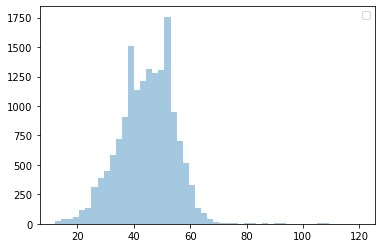

In [720]:
fact_lengths = [len(f['fact'].split()) for k in txt_dataset for f in txt_dataset[k]['SupportingFacts']]
print(np.mean(fact_lengths))
sns.distplot(fact_lengths, kde=False)
plt.legend()

In [11]:
import nltk
from nltk.corpus import stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*|\(|\)|-')

In [31]:
def get_sen2score_from_indx(k):
    #k = "13"
    #if random.random() > 0.05: continue
    print('k = ', k)
    Q = txt_dataset[str(k)]['Q']
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    titlewords = set()
    anchor2page = {}
    for f in txt_dataset[str(k)]['SupportingFacts']:
        fact_title_raw = ' '.join(urllib.parse.unquote(f['url']).split('/')[-1].split('_'))
        fact_title = pattern.sub('', fact_title_raw)
        titlewords = titlewords.union(fact_title.split())
        print(fact_title)
        for title in wikipedia.search(fact_title_raw):
            anchor2page[title] = "https://en.wikipedia.org/wiki/" + "_".join(title.split())
    print(len(anchor2page))
    keywords = keywords - PUNCTUATIONS
    titlewords = titlewords - PUNCTUATIONS
    for f in txt_dataset[str(k)]['SupportingFacts']:
        d = find_pages_by_hyperlink(keywords.union(titlewords), f['url'])
        anchor2page.update(d)
        print(len(anchor2page))
    #pprint(anchor2page)
    
    A = txt_dataset[str(k)]['A']
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS
    goldfactwords = set()
    Q_A_words = keywords.union(answerwords)
    for f in txt_dataset[str(k)]['SupportingFacts']:
        doc = nlp(f['fact'])
        goldfactwords = goldfactwords.union(set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())]) - Q_A_words)
    goldfactwords = goldfactwords - PUNCTUATIONS 
    print("keywords = ", keywords)
    print("titlewords = ", titlewords)
    print("answerwords = ", answerwords)
    print("goldfactwords = ", goldfactwords)
    print(" -- find sentences from each page --")
    sen2score = {}
    for title in anchor2page:
        try:
            if is_disambiguation_page(anchor2page[title]):
                print("disambiguation page: ", title)
                continue
        except:
            print(anchor2page[title])
        sen2score.update(find_sentences_from_page(title, anchor2page[title], keywords, answerwords, goldfactwords))
    print("total num of sentences found = ", len(sen2score))
    word_lists = [titlewords, keywords, goldfactwords, answerwords]
    return sen2score, word_lists

In [13]:
def highlight_words(word_lists, colors, sentence):
    s = copy.deepcopy(sentence)
    for word_list, color in zip(word_lists, colors):
        if "".join(word_list): s = re.sub(r'\b(' + r'|'.join(word_list) + r')\b\s*', lambda m: '<span style="background-color:rgb{}">{}</span>'.format(color, m.group()), s)
    return s

In [32]:
def add_html_row(k, sen2score, word_lists, colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]):
    html = ""
    html += '<tr><td>{}.</td><td>Q: {}<br>'.format(k, highlight_words(word_lists, colors, txt_dataset[str(k)]['Q']))
    for f in txt_dataset[str(k)]['SupportingFacts']:
        #words = f['fact'].split()
        #for i in range(len(words)):
            #w = words[i]
            #if w in keywords:
                #words[i] = '<span style="background-color:rgb(193, 239, 253)">{}</span>'.format(w)
        html += '<br><br>&nbsp;&nbsp;{}'.format(highlight_words(word_lists, colors, f['fact']))
        html += '<a href="{}"> link</a>'.format(f['url'])
    html += '<br><br>A: {}<br>'.format(highlight_words(word_lists, colors, txt_dataset[str(k)]['A']))
    html += '</td><td>'
    s_buckets = defaultdict(lambda: [])
    for s in sen2score:
        if sen2score[s]['scores'][4] > 0.14 and sen2score[s]['scores'][2] == 0.0 and len(s.split()) in range(22, 60):
            s_buckets['good'].append(s)
        elif sen2score[s]['scores'][4] < 0.14 and sen2score[s]['scores'][4] > 0.06 and sen2score[s]['scores'][2] == 0.0 and len(s.split()) in range(22, 60):
            s_buckets['okay'].append(s)
        elif sen2score[s]['scores'][1] > 0.0 or sen2score[s]['scores'][2] > 0.0:
            s_buckets['(maybe)falseneg'].append(s)
    for b in ['good', 'okay', '(maybe)falseneg']:
        html += '<strong> ----------------- {} ---------------- </strong><br>'.format(b)
        for s in random.sample(s_buckets[b], min(len(s_buckets[b]), 5)):
            #if sen2score[s]['scores'][4] > th and sen2score[s]['scores'][2] == 0.0 and len(s.split()) in range(22, 60):
            
            html += '{} --- {} '.format(highlight_words(word_lists, colors, s), str(sen2score[s]['scores']))
            html += '<a href="{}"> {}</a><br><br>'.format(sen2score[s]['link'], sen2score[s]['title'])
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html

In [15]:
sampled_indx = [23, 5199, 2892, 1489, 5713, 6793, 217, 2192, 934, 1859, 4804, 4311, 741, 5264, 1223]

In [16]:
PUNCTUATIONS = set(string.punctuation) - set(['.'])

In [1144]:
[(t.text, t.pos_) for t in nlp("SS-N-22 Sunburn is the NATO reporting name for two unrelated Soviet anti-ship missiles. Although the missiles were very different, distinguishing between them is difficult because their ship-mounted launching containers were identical.")]

[('SS', 'NOUN'),
 ('-', 'PUNCT'),
 ('N-22', 'PROPN'),
 ('Sunburn', 'PROPN'),
 ('is', 'AUX'),
 ('the', 'DET'),
 ('NATO', 'PROPN'),
 ('reporting', 'NOUN'),
 ('name', 'NOUN'),
 ('for', 'ADP'),
 ('two', 'NUM'),
 ('unrelated', 'ADJ'),
 ('Soviet', 'ADJ'),
 ('anti', 'ADJ'),
 ('-', 'ADJ'),
 ('ship', 'ADJ'),
 ('missiles', 'NOUN'),
 ('.', 'PUNCT'),
 ('Although', 'SCONJ'),
 ('the', 'DET'),
 ('missiles', 'NOUN'),
 ('were', 'VERB'),
 ('very', 'ADV'),
 ('different', 'ADJ'),
 (',', 'PUNCT'),
 ('distinguishing', 'VERB'),
 ('between', 'ADP'),
 ('them', 'PRON'),
 ('is', 'AUX'),
 ('difficult', 'ADJ'),
 ('because', 'SCONJ'),
 ('their', 'PRON'),
 ('ship', 'NOUN'),
 ('-', 'PUNCT'),
 ('mounted', 'VERB'),
 ('launching', 'VERB'),
 ('containers', 'NOUN'),
 ('were', 'VERB'),
 ('identical', 'ADJ'),
 ('.', 'PUNCT')]

In [33]:
html = "<html><body>"
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=gray><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
count = 0
for k in sampled_indx:
    count += 1
    sen2score, word_lists = get_sen2score_from_indx(k)
    html += add_html_row(k, sen2score, word_lists)
    o = open('distractor_demo.html', 'wt')

    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('distractor_demo.html', 'wt')

o.write(html)
o.close()

k =  23
21st Army Group
British Army Rhine
19
19
34
keywords =  {'21st', 'British', 'more', 'Group', 'less', 'corps', 'Army', 'armies', 'Rhine'}
titlewords =  {'21st', 'British', 'Group', 'Army', 'Rhine'}
answerwords =  set()
goldfactwords =  {'division', 'William', 'occupation', 'Harry', 'Canadian', 'Simpson', 'General', 'Southern', 'Division', 'divisions', 'time', '29th', 'Major', 'Commanded', 'Crerar', 'Miles', 'Ninth', 'March', 'Rhineland', 'US', '1919', 'two', 'forces', 'cavalry', 'First', '1945', 'Second', 'five', 'Dempsey', 'Allied', 'first', 'Heneker'}
 -- find sentences from each page --
disambiguation page:  21st Army
disambiguation page:  Army of the Rhine (disambiguation)
total num of sentences found =  1224
k =  5199
Schelte Bolswert
Schelte Bolswert
10
27
27
keywords =  {'side', 'Magdalene', 'St.', 'man', 'horseback', 'two', 'Men', 'Crucifixion', 'figure', 'Virgin', 'John', 'Sponge', 'Cross', 'other', 'Mary', 'Christ', 'grand', 'composition'}
titlewords =  {'Schelte', 'Bo

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


total num of sentences found =  483
k =  2892
SEQU
Cheddi Jagan International Airport
20
54
61
keywords =  {'codes', 'Jagan', 'Airport', 'ICAO', 'Sucre', 'Cheddi', 'Mariscal', 'International'}
titlewords =  {'Jagan', 'Airport', 'SEQU', 'Cheddi', 'International'}
answerwords =  {'Mariscal', 'Sucre', 'International', 'Airport'}
goldfactwords =  {'South', 'IATA', 'right', 'SEQU', 'aircraft', 'passenger', 'Pichincha', 'airports', 'busiest', 'bank', 'SYCJ', 'movement', 'traffic', 'capital', 'one', 'airport', '41', 'south', 'main', 'international', 'Demerara', 'city', 'mi', 'cargo', 'Spanish', 'GEO', 'America', 'Timehri', 'Georgetown', 'Guyana', 'national', 'Province', 'UIO', 'kilometres', 'Ecuador', '25', 'Aeropuerto', 'Quito', 'Internacional', 'River'}
 -- find sentences from each page --
disambiguation page:  Geo
total num of sentences found =  109
k =  1489
Duchy Normandy
Frederick II, Duke Austria
20
32
46
keywords =  {'ducal', 'Europe', 'one', 'history', 'countries', 'point', 'leaders'

total num of sentences found =  1883
k =  1223
Princebishop
Priesthood Catholic Church
20
49
82
keywords =  {'church', 'priest', 'catholic', 'bishop', 'Prince'}
titlewords =  {'Priesthood', 'Catholic', 'Church', 'Princebishop'}
answerwords =  set()
goldfactwords =  {'bishops', 'secular', 'ruler', 'priests', 'three', 'Catholic', 'Catholics', 'presbyters', 'one', 'holy', 'other', 'prince', 'principality', 'doctrine', 'two', 'civil', 'sovereignty', 'ordained', 'Church', 'deacons', 'orders', 'common', 'priesthood'}
 -- find sentences from each page --
total num of sentences found =  1539


In [24]:
def find_sentences_from_page(title, page, keywords, answerwords, goldfactwords):
    try: 
        content = wikipedia.page(title, auto_suggest=False, redirect=True).content
        paragraphs = content[:content.find('== References ==')].split('\n')
        
    except: return {}
    #records = []
    sen2score = {}
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            for s in doc.sents:
                if len(s) < 10: 
                    continue
                nouns_in_s = [t.text for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A > 0.06:
                    #print(IoU_Q, IoU_A, s.text)
                    IoU_G = IoU(set(nouns_in_s), goldfactwords)
                    sen2score[s.text] = {'scores': (IoU_Q, IoU_A, IoU_G, IoU_Q - IoU_A, IoU_Q - IoU_A - IoU_G), 'link': page, 'title': title}
                #records.append(round(IoU_Q, 2))
    #print(records)

    #records = []
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            it1, it2 = tee(doc.sents)
            next(it2, None)
            for s1, s2 in zip(it1, it2):
                if len(s1) < 5 or len(s2) < 5 or len(s1)+len(s2) > 70 or len(s1)+len(s2) < 10: 
                    continue 
                nouns_in_s = [t.text for s in [s1, s2] for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A >= 0.06:
                    #print(IoU_Q, IoU_A, " ".join([s1.text, s2.text]))
                    IoU_G = IoU(set(nouns_in_s), goldfactwords)
                    sen2score[" ".join([s1.text, s2.text])] = {'scores': (IoU_Q, IoU_A, IoU_G, IoU_Q - IoU_A, IoU_Q - IoU_A - IoU_G), 'link': page, 'title': title}
                    #print(s)
                #records.append(round(IoU_Q, 2))
    #print(records)
    #print(len(sen2score))
    return sen2score

In [903]:
paragraphs = wikipedia.page("Egyptian mythology", auto_suggest=False, redirect=True).content.split('\n')

In [756]:
doc = nlp("The ancient Egyptians had an elaborate set of funerary practices that they believed were necessary to ensure their immortality after death. These rituals included mummifying the body, casting magic spells, and burials with specific grave goods thought to be needed in the afterlife.")
for s in doc.sents:
    print("sentence: -------------", len(s))
    for t in s:
        print(t.is_sent_start, t.i - s.start)

sentence: ------------- 22
True 0
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
sentence: ------------- 25
True 0
False 1
False 2
False 3
False 4
False 5
False 6
False 7
False 8
False 9
False 10
False 11
False 12
False 13
False 14
False 15
False 16
False 17
False 18
False 19
False 20
False 21
False 22
False 23
False 24


In [763]:
url = "https://en.wikipedia.org/wiki/Egyptian_tombs"
Q = 'What are three things thought to be required funerary practices by the people that thought that like Ra, their physical bodies, or Khat, would reawaken after they completed their journey through the underworld?'
req = urllib.request.Request(url, headers = {'User-Agent': random.choice(USER_AGENT_LIST)})
with urllib.request.urlopen(req) as f:
    html = f.read().decode('utf-8')
end_indx = html.find('<h2><span class="mw-headline" id="References">References</span>')
html = html[:end_indx]
soup = BeautifulSoup(html, 'html.parser')
soup.text

'\n\n\n\nAncient Egyptian funerary practices - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAncient Egyptian funerary practices\n\nFrom Wikipedia, the free encyclopedia\n\xa0\xa0(Redirected from Egyptian tombs)\n\n\nJump to navigation\nJump to search\nElaborate set of funerary practices\n The Opening of the Mouth ceremony being performed on a mummy before the tomb\nPart of a series onAncient Egyptian religion\nBeliefs\nAfterlife\nDuat\nMa\'at\nMythology\nNumerology\nPhilosophy\nSoul\n\nPractices\nFunerals\nOffering formula\nTemples\nPriestess of Hathor\nPyramids\n\nDeities (list)Ogdoad\nAmun\nAmunet\nHauhet\nHeh\nKauket\nKek\nNaunet\nNu\nEnnead\nAtum\nGeb\nIsis\nNephthys\nNut\nOsiris\nSet\nShu\nTefnut\nA\nAker\nAkhty\nAmmit\nAm-heh\nAnat\nAndjety\nAnhur\nAnput\nAnubis\nAnuket\nApedemak\nApep\nApis\nApt\nAqen\nArensnuphis\nAsh\nAssessors\nAstarte\nAten\nB\n\nBabi\nBanebdjedet\nBastet\nBat\nBata\nBa-Pef\nBennu\nBes\nBuchis\nC\n\nCavern deities\nD\n\nDedun\

In [19]:
def IoU(A, B):
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    return round(intersection / (union+1e-7), 2)

In [881]:
### Calculate num_sents, num_dots, IoU_Q for all positive facts
count = 0
num_sents = []
num_dots = []
IoU_Qs = []
IoU_As = []
IoU_Q_sub_As = []
for k in txt_dataset:
    if int(k) % 1000 == 999: print(k)
    if random.random() > 0.1: continue
    #print(k)
    count += 1
    Q = txt_dataset[k]['Q']
    doc = nlp(Q)
    keywords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    
    A = txt_dataset[k]['A']
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    #print(answerwords)
    for f in txt_dataset[k]['SupportingFacts']:
        keywords = keywords.union([urllib.parse.unquote(x) for x in f['url'].split('/')[-1].split('_')])
    for f in txt_dataset[k]['SupportingFacts']:
        doc = nlp(f['fact'])
        num_sents.append(len(list(doc.sents)))
        num_dots.append(f['fact'].count('.'))
        nouns_in_s = [t.text for t in doc if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]
        
        IoU_Q = IoU(set(nouns_in_s), keywords)
        IoU_Qs.append(IoU_Q)
        IoU_A = IoU(set(nouns_in_s), answerwords)
        IoU_As.append(IoU_A)
        IoU_Q_sub_As.append(IoU_Q - IoU_A)
    #break
print(count)
print(np.mean(IoU_Qs), np.std(IoU_Qs))
print(np.mean(num_sents), np.std(num_sents))
print(np.mean(num_dots), np.std(num_dots))


999
1999
2999
3999
4999
5999
6999
731
0.14349787194622898 0.09841205375478518
2.25689307330195 0.8937753983387692
2.453934095494284 1.2716436857249314


In [882]:
print(np.mean(IoU_As), np.std(IoU_As))
print(np.mean(IoU_Q_sub_As), np.std(IoU_Q_sub_As))

0.06880772929447361 0.0894684868478612
0.07469014265175539 0.12109388161553208


In [866]:
or_questions = []
for k in txt_dataset:
    if ' or '  in txt_dataset[k]['Q']:
        if random.random() < 0.05:
            print(txt_dataset[k]['Q'])
        or_questions.append(k)
print(len(or_questions))

Which person is more likely to code with fewer errors; Indra Joshi or Jagdish Joshi?
Were T.M. Parrott and Sir Thomas Perrot born on the same continent or different continents?
Are Rassolnik and Chicken soup made with the same meat or different meat?
Is it true that the only way to get an Intel processor slot to accept another processor it was designed for is to bend it left or right when installing it?
Was William John Battersby's male child dead or alive when the company eventually merged with several other hat makers?
Did the Buccaneers make it farther in the playoffs in 2001 or in 2002?
Replacing a coastal mangrove stand, roadside weeds or wheat fields is all called what?
Who created something first; Daniel Jones or Laurie Lee?
Was Guild single longer after her marriage to Russell or after her marriage to Martin?
Did Edgar, King of Scotland claim kingship before or after the birth of Sancho Alfónsez?
Which play was longer: Corey Rodgers' touchdown run in the 2003 Fort Worth Bowl or

In [907]:
records = []
for p in paragraphs:
    if len(p.split()) >= 10:
        records.append(-999)
        doc = nlp(p)
        for s in doc.sents:
            if len(s) < 5: 
                #print("------------ Short sentence: ", s)
                continue
            #intersection = np.sum(b in keywords for b in [t.text for t in s])
            nouns_in_s = [t.text for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]
            
            #print(nouns_in_s)
            IoU_Q = IoU(set(nouns_in_s), keywords)
            IoU_A = IoU(set(nouns_in_s), answerwords)
            if IoU_Q -  IoU_A > 0.08:
                print(IoU_Q, IoU_A, s.text)
                sen2score[s.text] = IoU_Q -  IoU_A
                #print(s)
                if records[-1] > 0: print("+++++++++++++++++ ", s)
            records.append(round(IoU_Q, 2))
print(records)

0.09523809523809523 0.0 The beliefs that these myths express are an important part of ancient Egyptian religion.
+++++++++++++++++  The beliefs that these myths express are an important part of ancient Egyptian religion.
0.08695652173913043 0.0 Events from the present that might be regarded as myths include Ra's daily journey through the world and its otherworldly counterpart, the Duat.
+++++++++++++++++  Events from the present that might be regarded as myths include Ra's daily journey through the world and its otherworldly counterpart, the Duat.
0.1 0.0 Scholars have difficulty defining which ancient Egyptian beliefs are myths.
0.09523809523809523 0.0 Frankfort's arguments are the basis for much of the more recent analysis of Egyptian beliefs.
+++++++++++++++++  Frankfort's arguments are the basis for much of the more recent analysis of Egyptian beliefs.
0.09523809523809523 0.0 Political changes affected Egyptian beliefs, but the ideas that emerged through those changes also have dee

In [910]:
records = []
for p in paragraphs:
    if len(p.split()) >= 10:
        records.append(-999)
        doc = nlp(p)
        it1, it2 = tee(doc.sents)
        next(it2, None)
        for s1, s2 in zip(it1, it2):
            if len(s1) < 5 or len(s2) < 5 or len(s1)+len(s2) > 70: 
                #print("------------ Short sentence: ", s)
                continue
            #intersection = np.sum(b in keywords for b in [t.text for t in s])
            nouns_in_s = [t.text for s in [s1, s2] for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]
            
            #print(nouns_in_s)
            IoU_Q = IoU(set(nouns_in_s), keywords)
            IoU_A = IoU(set(nouns_in_s), answerwords)
            if IoU_Q -  IoU_A >= 0.06:
                print(IoU_Q, IoU_A, " ".join([s1.text, s2.text]))
                sen2score[" ".join([s1.text, s2.text])] = IoU_Q -  IoU_A
                #print(s)
                #if records[-1] > 0: print("+++++++++++++++++ ", " ".join([s1.text, s2.text]))
            records.append(round(IoU_Q, 2))
print(records)
print(len(records))

0.07142857142857142 0.0 Egyptian mythology is the collection of myths from ancient Egypt, which describe the actions of the Egyptian gods as a means of understanding the world around them. The beliefs that these myths express are an important part of ancient Egyptian religion.
0.08823529411764706 0.0 The beliefs that these myths express are an important part of ancient Egyptian religion. Myths appear frequently in Egyptian writings and art, particularly in short stories and in religious material such as hymns, ritual texts, funerary texts, and temple decoration.
0.07407407407407407 0.0 In ancient Egypt, the earliest evidence of religious practices predates written myths. Rituals early in Egyptian history included only a few motifs from myth.
0.06896551724137931 0.0 Scholars have difficulty defining which ancient Egyptian beliefs are myths. The basic definition of myth suggested by the Egyptologist John Baines is "a sacred or culturally central narrative".
0.06451612903225806 0.0 The Eg

0.07692307692307693 0.0 In his passage Ra also brings light to the Duat, enlivening the blessed dead who dwell there. In contrast, his enemies—people who have undermined maat—are tormented and thrown into dark pits or lakes of fire.
0.11538461538461539 0.0 In contrast, his enemies—people who have undermined maat—are tormented and thrown into dark pits or lakes of fire. The key event in the journey is the meeting of Ra and Osiris.
0.1111111111111111 0.0 The key event in the journey is the meeting of Ra and Osiris. In the New Kingdom, this event developed into a complex symbol of the Egyptian conception of life and time.
0.06666666666666667 0.0 When Ra and Osiris meet, they merge into a single being. Their pairing reflects the Egyptian vision of time as a continuous repeating pattern, with one member (Osiris) being always static and the other (Ra) living in a constant cycle.
0.0967741935483871 0.0 Their pairing reflects the Egyptian vision of time as a continuous repeating pattern, with 

In [813]:
for s in sen2score:
    v= sen2score[s]
    if v > 0.1:
        print(v, s)

0.10344827586206896 In looking at the bones of the mummified bodies, experts get a better idea of the average height and life span. Studying Ancient Egyptian Mummies, archaeologists are able to learn about the past.
0.11403508771929824 One important factor in the development of Ancient Egyptian tombs was the need of storage space for funerary goods.
0.10526315789473684 In Ancient Egypt death was seen as a boat journey.
0.1111111111111111 The Ancient Egyptian Books of the Afterlife.
0.10526315789473684 Mark, Joshua J. “Ancient Egyptian Burial”.
0.10714285714285714 Since the people regarded Ra as a principal god, creator of the universe and the source of life, he had a strong influence on them, which led to him being one of the most worshiped of all the Egyptian gods and even considered King of the Gods.
0.1111111111111111 When Ra was in the underworld, he would visit all of his various forms.
0.10526315789473684 When Ra was in the underworld, he merged with Osiris, the god of the dead.


In [599]:
### Scrap imgs and their captions. 
url = 'https://en.wikipedia.org/wiki/Forest_Red_Gum'
req = urllib.request.Request(url, headers = {'User-Agent': random.choice(USER_AGENT_LIST)})
with urllib.request.urlopen(req) as f:
    html = f.read().decode('utf-8')
end_indx = html.find('<h2><span class="mw-headline" id="References">References</span>')
html = html[:end_indx]
soup = BeautifulSoup(html, 'html.parser')
#links = soup.find_all('img', {'src':re.compile('.jpg|.png')})
links = soup.find_all('img')
print(len(links))
for l in links:
    imgUrl = l.get('src')
    #if "http" not in imgUrl: imgUrl = "https://" + url.split("/")[2] + imgUrl
    if int(l['width'])<100 or int(l['height'])<100:
        continue
    if any(b in imgUrl.lower() for b in url_blocklist): 
        continue
    print(" --------------------------------------------------------------- ")
    print(imgUrl)
    
    # Special case for thumb images, which are located inside a table
    thumbinner_div = l.find_parent("div", class_='thumbinner')
    if thumbinner_div: 
        print("parent thumbinner<div>: ", thumbinner_div.text)
        continue
        
    tr_parent = l.find_parent('tr')
    if tr_parent: print("parent<tr>: ", tr_parent.text)
        
    next_p = l.find_next('p')
    if next_p: print("<p>: ", next_p.text)
                
    prev_th = l.find_previous('th')
    if prev_th: print("prev<th>: ", prev_th.text)
    
    prev_p = l.find_previous('p')
    if prev_p: print("prev<p>: ", prev_p.text)


15
 --------------------------------------------------------------- 
//upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Eucalyptus_tereticornis_-_full_tree.jpg/220px-Eucalyptus_tereticornis_-_full_tree.jpg
parent<tr>:  


<p>:  Eucalyptus tereticornis, commonly known as forest red gum, blue gum or red irongum,[2] is a species of tree that is native to eastern Australia and southern New Guinea. It has smooth bark, lance-shaped to curved adult leaves, flower buds in groups of seven, nine or eleven, white flowers and hemispherical fruit.

prev<th>:  Forest red gum, blue gum, red irongum

prev<p>:  

 --------------------------------------------------------------- 
//upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Eucalyptus_terticornis_trees.jpg/220px-Eucalyptus_terticornis_trees.jpg
parent thumbinner<div>:   E. tereticornis trees


In [597]:
#html.find('<h2><span class="mw-headline" id="References">References</span>')
html[106916:106929]

'<h2><span cla'